## Прогнозирование группы пользователей для осуществления таргетированной рекламы банковского продукта

### Описание проекта
Задача банка предложить потребительский кредит и при этом максимизировать [показатель конверсии](https://www.unisender.com/ru/support/about/glossary/chto-takoe-cr-conversion-rate/), который равен отношению количества пользователей, принявших кредит, к общему количеству пользователей, которым поступили предложения *(precision)*. Решение этой задачи актуально для банка, потому что это позволит сократить расходы на персональный маркетинг, но при этом достичь максимальной выгоды. Данный проект оптимизирует выбор кандидатов для персонального предложения о предоставлении кредита. В процесс отбора кандидатов можно внерить алгоритм отсева потенциальных кандидатов, готовых взять кредит. 
### Постановка бизнес и математической задачи
Предположительно, нам известно сколько было затрачено времени и средств на проведение прошлогодней кампании. Для измерения бизнес цели мы планируем использовать сравнение затраченных и полученных средств текущей и прошлогодней кампании. Критерий успеха — доход, превышающий доход прошлогодней кампании (или превышение предсказанных показателей дохода, тк может быть тренд увеличения прибыли).

С математической точки зрения мы хотим, чтобы как можно больше людей из тех, кого мы выберем приняли наше предложение. Нам требуется построить бинарный классификатор, с вероятностными прогнозами. Для повышения показателя конверсии нам необходимо оптимизировать precision, но так же необходимо охватить больше потенциально согласных пользователей, поэтому мы будем оптимизировать __F1 score__ и следить за __precision__.

### Особенности предметной области
Для банковской сферы показатели качества часто бывают гораздо менее важными, чем простота самой модели и простота ее интерпретации. Это следует учесть при выборе финальной модели.

### Содержание 
+ [Описание колонок](#description_cell)
+ [EDA](#eda_cell)
+ [Train/Test split](#split_metrics_cell)
+ [Baseline](#baseline_cell)
+ [Feature engineering](#feature_cell)
+ [Model building](#model_cell)
+ [Conclusion](#conclusion_cell)

In [23]:
# imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score

from sklearn.pipeline import Pipeline, TransformerMixin
from sklearn.base import BaseEstimator

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

from graphviz import Source
from sklearn import tree

RANDOM_STATE = 12

In [24]:
file_name = "BPL.csv"
df = pd.read_csv(file_name)
df.head(5)

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


<a id='description_cell'></a>

## Описание колонок
* **ID** : ID пользователя

* **Age** : Число полных лет пользователя

* **Experience** : Стаж работы

* **Income** : Годовой доход в тысячах долларов

* **ZIP Code** : Почтовый индекс

* **Family** : Размер семьи

* **CCAvg** : Средняя трата по кредитной карте за месяц

* **Education** : Степень образования.
   1. Среднее  
   2. Высшее  
   3. Доктор наук  
   

* **Mortgage** : Стоимость ипотеки при наличии. (в тысячах долларов)

* **Personal Loan** : Принял ли клиент предожение в прошлогодней кампании

* **Securities Account** : Есть ли у клиента счет в банке с ценными бумагами(брокерский счет)

* **CD Account** : Есть ли у клиента банковский вклад

* **Online** : Пользуется ли клиент услугами интернет - банкинга?

* **Credit card** : Использует ли клиент кредитную карту, выпущенную банком

<a id='eda_cell'></a>

# EDA

In [25]:
# there are no missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
ID                    5000 non-null int64
Age                   5000 non-null int64
Experience            5000 non-null int64
Income                5000 non-null int64
ZIP Code              5000 non-null int64
Family                5000 non-null int64
CCAvg                 5000 non-null float64
Education             5000 non-null int64
Mortgage              5000 non-null int64
Personal Loan         5000 non-null int64
Securities Account    5000 non-null int64
CD Account            5000 non-null int64
Online                5000 non-null int64
CreditCard            5000 non-null int64
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


Видим, что все колонки имеют тип данных int64. Так как в датасете присутствует 5000 семплов, пропущенных значений не наблюдается.
Некоторые колонки можно интерпретировать одновременно и как категориальные, и как номенативные.

In [26]:
# numeric and categorical features
num_cols = ['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage', 'Family', 'Education', 'ZIP Code']
intersection_cols = ['Education', 'Family']
cat_cols = list((set(df.columns) - set(num_cols)).union(set(intersection_cols)))

print('Numeric Columns:', num_cols)
print('Categorical Columns:', cat_cols)
print('Intersection Columns:', intersection_cols)

Numeric Columns: ['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage', 'Family', 'Education', 'ZIP Code']
Categorical Columns: ['ID', 'CreditCard', 'Personal Loan', 'Online', 'Education', 'Family', 'Securities Account', 'CD Account']
Intersection Columns: ['Education', 'Family']


In [27]:
df.describe()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.104600,73.774200,93152.503000,2.396400,1.937938,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,1443.520003,11.463166,11.467954,46.033729,2121.852197,1.147663,1.747659,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,1.000000,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,2500.500000,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,3750.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [28]:
df.describe().loc['min']

ID                       1.0
Age                     23.0
Experience              -3.0
Income                   8.0
ZIP Code              9307.0
Family                   1.0
CCAvg                    0.0
Education                1.0
Mortgage                 0.0
Personal Loan            0.0
Securities Account       0.0
CD Account               0.0
Online                   0.0
CreditCard               0.0
Name: min, dtype: float64

In [29]:
print(df[df['Experience'] < 0].shape)
df[df['Experience'] < 0].sample(10)

(52, 14)


,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
2962,2963,23,-2,81,91711,2,1.8,2,0,0,0,0,0,0
536,537,25,-1,43,92173,3,2.4,2,176,0,0,0,1,0
3626,3627,24,-3,28,90089,4,1.0,3,0,0,0,0,0,0
576,577,25,-1,48,92870,3,0.3,3,0,0,0,0,0,1
3394,3395,25,-1,113,90089,4,2.1,3,0,0,0,0,1,0
2980,2981,25,-1,53,94305,3,2.4,2,0,0,0,0,0,0
4411,4412,23,-2,75,90291,2,1.8,2,0,0,0,0,1,1
2848,2849,24,-1,78,94720,2,1.8,2,0,0,0,0,0,0
597,598,24,-2,125,92835,2,7.2,1,0,0,1,0,0,1
540,541,25,-1,109,94010,4,2.3,3,314,0,0,0,1,0


В колонке Experience мы можем наблюдать отрицательные значения. Это могут быть различные категории/причины отсутствия опыта работы у людей. Данный момент следует уточнить у заказчика, либо внедрить какие-то изменения в колонку Experience.

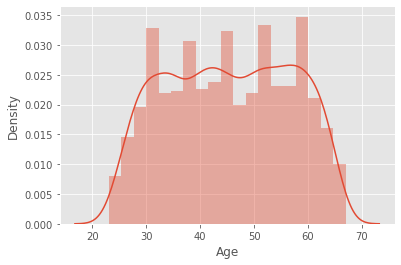

In [30]:
sns.distplot(df['Age'])
plt.show()

In [31]:
df['Personal Loan'].value_counts()

0    4520
1     480
Name: Personal Loan, dtype: int64

Мы имеем дело с бинарной классификацией по сильно несбалансированной выборке(9:1)  
Рассмотрим корреляцию признаков

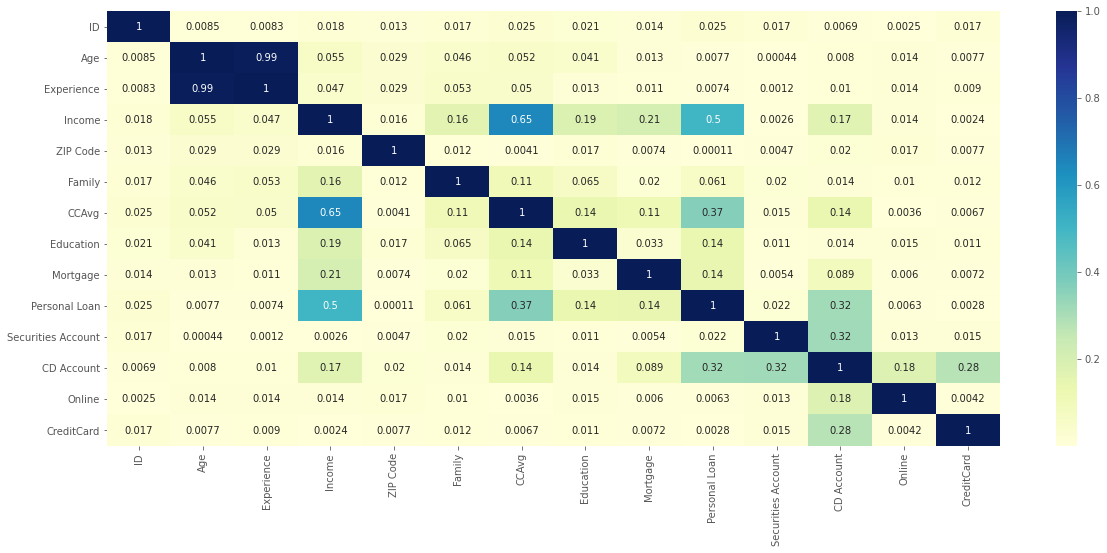

In [32]:
plt.figure(figsize=(20,8))
sns.heatmap(abs(df.corr()), annot=True, fmt='.2g',cmap='YlGnBu')
plt.show()

Видно, что признаки **Experience** и **Age** коррелируют, следовательно, мы можем оставить в данных какой-нибудь один из них

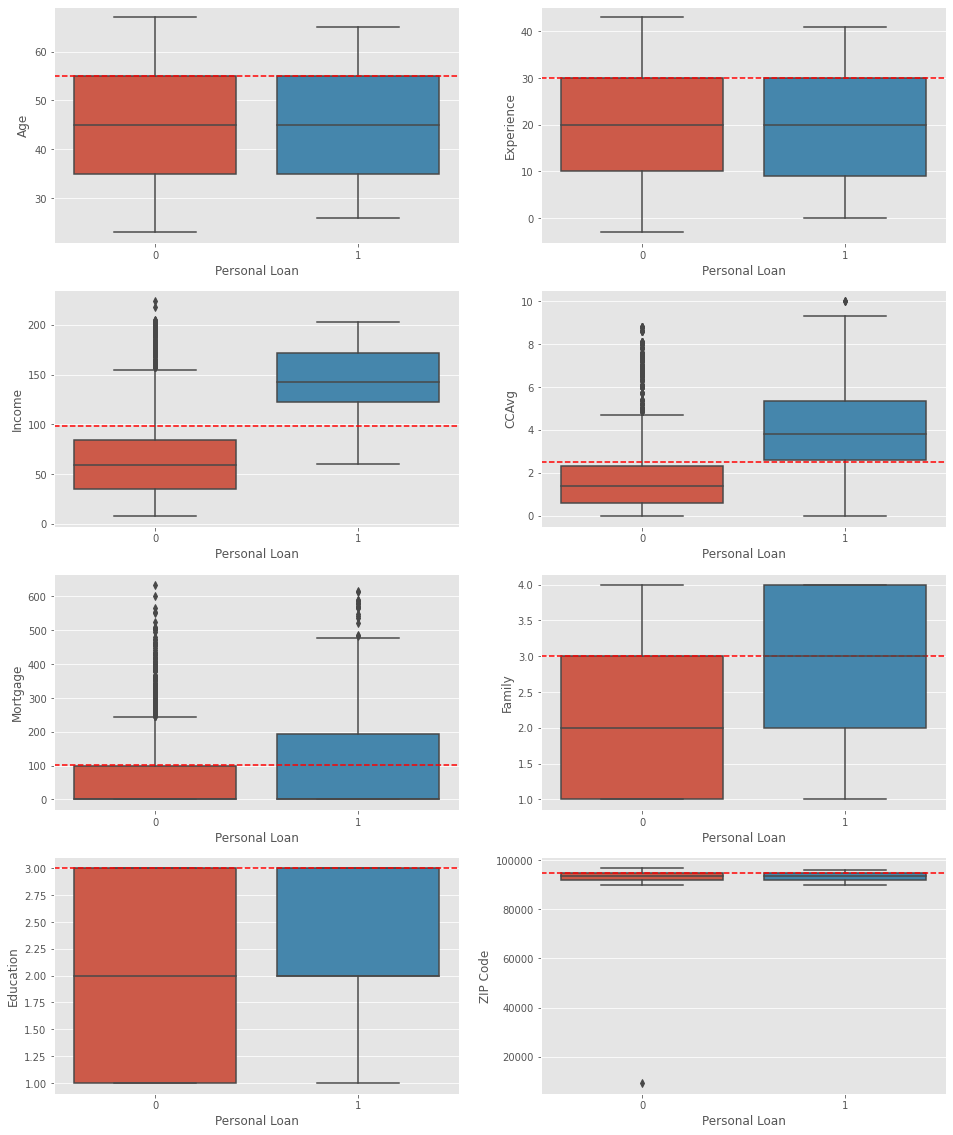

In [33]:
# feature importance
fig, ax = plt.subplots(4, 2, figsize=(16, 20))

for current_column, axis in zip(num_cols, ax.flatten()):
    sns.boxplot(x='Personal Loan', y=current_column, data=df, ax=axis)
    axis.axhline(df.describe().loc['75%', current_column], ls='--', c='red')

Из графиков видно, что:
* **Age** и **Experience** помимо того, что сильно коррелируют друг с другом, плохо предсказывают целевую переменную
* **Mortgage** имеет много нулевых значений, следовательно имеет смысл сделать отдельно категориальную колонку, отвечающую за наличие у человека иппотеки
* Аналогично предыдущему пункту, имеет смысл добавить к **Family** категориальную составляющую, так как наличие членов семьи сильно влияет на целевую переменную
* **Income** и **CCAvg** являются самымим информативными для предсказания таргета

<a id='split_metrics_cell'></a>

# Train/test split + metrics

In [34]:
target_col = ['Personal Loan']

X, y = df.drop(target_col, axis=1), df[target_col]
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                            stratify = y, random_state=RANDOM_STATE)
metrics = {'accuracy': accuracy_score,
           'precision': precision_score,
           'recall': recall_score,
           'roc_auc': roc_auc_score, 
           'f1': f1_score}

<a id='baseline_cell'></a>

# Baseline

Из графиков видно, что параметр дохода явлеется самым информативнм для нас. Сейчас, для выбора пользователей, которые получат персональные предложения, банк искользовал разделение по уровню дохода. Данная модель является имеет слабую конверсию, однако является очень простой в интерпретации для конечного пользователя, что очень важно в банковской сфере. 
Будем отталкиваться от разбиения по параметру Income.

In [35]:
means = df.groupby('Personal Loan')['Income'].mean()
means

Personal Loan
0     66.237389
1    144.745833
Name: Income, dtype: float64

In [36]:
threshold = means.mean()
def baseline_predict(df):
    return df['Income']>threshold
print('Baseline results')
bpred=baseline_predict(X_test_raw)
for score_name, score in metrics.items():
        print(score_name+': '+str(score(y_test,bpred)))

Baseline results
accuracy: 0.854
precision: 0.39035087719298245
recall: 0.9270833333333334
roc_auc: 0.8866611356932155
f1: 0.5493827160493827


<a id='feature_cell'></a>

# Feature engineering

In [37]:
train_columns = []

class FeatureSelector(TransformerMixin, BaseEstimator):
    '''
    Custom Transforemr.
    Drops columns: ID, ZIP Code,'Age, Experience.
    '''

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # transform X via code or additional methods
        
        # опустим коды сотрудников (ID, ZIP Code),
        # а также признаки Age и Experience, в связи с их неинформативностью
        X = X.drop(["ID", "ZIP Code", 'Age', 'Experience'], axis=1) 
        
        global train_columns
        train_columns = X.columns

        return X
    
    
class FeatureGemerator(TransformerMixin, BaseEstimator):
    '''
    Custom Transforemr.
    Creates several categorical columns
    '''
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # transform X via code or additional methods
        
        # is sth features
        X['IsMortgaged'] = X['Mortgage'] > 0
        X['IsFamily'] = X['Family'] > 1
        X['IsEducated'] = X['Education'] > 1

        # Is > than 75 qq
        X['IsMortgaged75'] = (X['Mortgage'] > X.describe().loc['75%', 'Mortgage']) & X['IsMortgaged']
        X['IsIncome75'] = X['Income'] > X.describe().loc['75%', 'Income']
        X['IsCCAvg75'] = X['CCAvg'] > X.describe().loc['75%', 'CCAvg']
        
        return X
    
def add_layer_to_pipeline(pipeline, layer,
                             pipeline_name='pipe', layer_name='model'):
    new_pipeline = Pipeline([
        (pipeline_name, pipeline),
        (layer_name, layer)
    ])
    
    return new_pipeline

In [38]:
# creating a pipeline to preprocess data in future
data_engeneering_pipeline = Pipeline([
    ('feature_generator', FeatureGemerator()),
    ('feature_selector', FeatureSelector())
#    ('scaler', StandardScaler())
])

# savling pipeline
joblib.dump(data_engeneering_pipeline, 'data_engeneering_pipeline.pkl')

['data_engeneering_pipeline.pkl']

<a id='model_cell'></a>

## Построение модели

В связи с особенностями предметной области, выбор финальной модели будет стоять из просто-интерпретируемых моделей, таких как Деревья решений и Линейные модели. Также необходимо оценить насколько данные модели будут уступать наиболее популярным аналогам для решения задач с табличными данными. 

In [39]:
# results of preprocessing
X_train = data_engeneering_pipeline.fit_transform(X_train_raw)
X_test = data_engeneering_pipeline.fit_transform(X_test_raw)

In [40]:
X_train


,Income,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard,IsMortgaged,IsFamily,IsEducated,IsMortgaged75,IsIncome75,IsCCAvg75
4850,119,1,2.9,1,0,1,0,1,0,False,False,False,False,True,True
3041,92,2,0.6,1,0,0,0,1,0,False,True,False,False,False,False
2647,155,1,2.9,1,0,0,0,1,0,False,False,False,False,True,True
549,35,3,1.3,2,0,0,0,0,1,False,True,True,False,False,False
2809,185,3,2.2,2,0,1,1,1,1,False,True,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,161,3,6.5,2,485,1,1,0,0,True,True,True,True,True,True
1512,44,3,1.7,1,0,0,0,0,0,False,True,False,False,False,False
4471,79,3,0.8,1,302,0,0,0,0,True,True,False,True,False,False
4260,52,1,1.4,1,0,0,0,1,0,False,False,False,False,False,False


In [41]:
# initializing models, their params and metrics



cat_features=['IsMortgaged','IsFamily','IsEducated','IsMortgaged75','IsIncome75','IsCCAvg75',
             'Education','Mortgage', 'Securities Account', 'CD Account', 'Online', 'CreditCard']
models = {'CatBoostClassifier' : CatBoostClassifier(),
          'RandomForestClassifier': RandomForestClassifier(),
          # 'LogisticRegression': LogisticRegression(),
          'DecisionTreeClassifier': DecisionTreeClassifier(),
          # 'KNeighborsClassifier': KNeighborsClassifier(),
          'GradientBoostingClassifier': GradientBoostingClassifier(),
         
         }

params = {'LogisticRegression': {'C': np.linspace(0.01,2,15),
                                 'penalty': ['l1','l2', 'elasticnet', 'none'], 
                                 'random_state': [RANDOM_STATE]},
          'RandomForestClassifier': {'max_features': [1,3,10],
                                      'min_samples_split': [2,3,10],
                                      'min_samples_leaf': [1,3,10],
                                      'bootstrap': [False, True],
                                      'n_estimators': [50, 100, 200, 300],
                                      'n_jobs': [-1], 
                                      'random_state': [RANDOM_STATE]},
          'DecisionTreeClassifier': {'splitter': ['best', 'random'],
                                     'max_depth': ['none'] + [i for i in range(3, 9)], 
                                     'random_state': [RANDOM_STATE]},
          'KNeighborsClassifier':  {'n_neighbors': np.arange(1,50),
                                    'weights': ['uniform', 'distance']},
          'GradientBoostingClassifier': {'learning_rate': [0.001,0.01,0.1,0.05],
                                         'n_estimators': [100,500,1000],
                                         'max_depth': [3,5,10],
                                         'min_samples_split': [2,5,10], 
                                         'random_state': [RANDOM_STATE]},
          'CatBoostClassifier' : {'iterations':[500],
                                'depth' : [8],
                                'learning_rate' :[0.03],
                                 'l2_leaf_reg' : [3],
                                'eval_metric':["F1"],
                                'loss_function' : ["Logloss"],
                                #'task_type' : ["GPU"],
                                'leaf_estimation_iterations' : [10],
                                'max_ctr_complexity' : [5,8],
                                'random_seed': [RANDOM_STATE],
                                'cat_features'  : [ cat_features]}
}


In [42]:
def train_grdsearch_and_evaluate(X_train, y_train, X_test, y_test, 
                                 models=models, params=params, metrics=metrics, 
                                 n_jobs=-1, verbose=1, scoring='f1', n_splits=5):
    '''
    Returns a matrix (pd.DataFrame) of scores, dict of best_models \
    and dict of their best validation_scores(roc_auc)  
    '''
    
    best_scores={}
    best_estimators={}
    
    df_models = []
    df_training_scores = []
    df_scores = {metric_name:[] for metric_name, _ in metrics.items()}
    
    df = pd.DataFrame(columns=['model']) 
    for model_name, model in models.items():
        search = GridSearchCV(model, param_grid=params[model_name], 
                              cv=StratifiedKFold(n_splits=n_splits), scoring=scoring,
                              n_jobs=n_jobs, verbose=verbose).fit(X_train, y_train)
        
        best_scores[model_name] = search.best_score_
        best_estimators[model_name] = search.best_estimator_       
        print(f'Model: {model_name},\nBest score: \
        {best_scores[model_name]}\nBest params: {best_estimators[model_name]}')            
        
        df_models.append(model_name)
        for score_name, score in metrics.items():
            # f1 and accuracy don't work with probas
            # Also RFClassifier don't have predict_proba
            try:
                preds = search.predict_proba(X_test)
                df_scores[score_name].append(score(y_test, preds))
            except Exception as e:
                preds = search.predict(X_test)
                df_scores[score_name].append(score(y_test, preds))
    df['model'] = df_models   
    for score_name, _ in df_scores.items():
        df[score_name] = df_scores[score_name]    
    return df, best_estimators, best_scores

In [43]:
%%time
scoring_df, best_params, best_scores = train_grdsearch_and_evaluate(X_train, y_train, X_test, y_test, scoring='f1')

Fitting 5 folds for each of 2 candidates, totalling 10 fits
0:	learn: 0.6137725	total: 158ms	remaining: 1m 18s
1:	learn: 0.9205922	total: 188ms	remaining: 46.7s
2:	learn: 0.9177127	total: 218ms	remaining: 36.1s
3:	learn: 0.9185393	total: 248ms	remaining: 30.7s
4:	learn: 0.9254144	total: 279ms	remaining: 27.6s
5:	learn: 0.9108911	total: 297ms	remaining: 24.5s
6:	learn: 0.9108911	total: 332ms	remaining: 23.3s
7:	learn: 0.9078014	total: 346ms	remaining: 21.3s
8:	learn: 0.8936782	total: 358ms	remaining: 19.5s
9:	learn: 0.8965517	total: 399ms	remaining: 19.5s
10:	learn: 0.8984263	total: 416ms	remaining: 18.5s
11:	learn: 0.8984263	total: 431ms	remaining: 17.5s
12:	learn: 0.9002849	total: 460ms	remaining: 17.2s
13:	learn: 0.9049645	total: 494ms	remaining: 17.2s
14:	learn: 0.9049645	total: 513ms	remaining: 16.6s
15:	learn: 0.9080622	total: 551ms	remaining: 16.7s
16:	learn: 0.9096045	total: 576ms	remaining: 16.4s
17:	learn: 0.9111425	total: 609ms	remaining: 16.3s
18:	learn: 0.9172511	total: 646

160:	learn: 0.9800797	total: 5.26s	remaining: 11.1s
161:	learn: 0.9800797	total: 5.29s	remaining: 11s
162:	learn: 0.9800797	total: 5.32s	remaining: 11s
163:	learn: 0.9800797	total: 5.37s	remaining: 11s
164:	learn: 0.9800797	total: 5.41s	remaining: 11s
165:	learn: 0.9800797	total: 5.42s	remaining: 10.9s
166:	learn: 0.9800797	total: 5.46s	remaining: 10.9s
167:	learn: 0.9800797	total: 5.5s	remaining: 10.9s
168:	learn: 0.9814324	total: 5.55s	remaining: 10.9s
169:	learn: 0.9854690	total: 5.6s	remaining: 10.9s
170:	learn: 0.9854690	total: 5.65s	remaining: 10.9s
171:	learn: 0.9854690	total: 5.69s	remaining: 10.8s
172:	learn: 0.9854690	total: 5.78s	remaining: 10.9s
173:	learn: 0.9854690	total: 5.82s	remaining: 10.9s
174:	learn: 0.9854690	total: 5.87s	remaining: 10.9s
175:	learn: 0.9854690	total: 5.9s	remaining: 10.9s
176:	learn: 0.9854690	total: 5.95s	remaining: 10.9s
177:	learn: 0.9854690	total: 6.01s	remaining: 10.9s
178:	learn: 0.9854690	total: 6.05s	remaining: 10.9s
179:	learn: 0.9854690	t

319:	learn: 0.9947644	total: 12.1s	remaining: 6.78s
320:	learn: 0.9947644	total: 12.1s	remaining: 6.74s
321:	learn: 0.9947644	total: 12.1s	remaining: 6.7s
322:	learn: 0.9947644	total: 12.2s	remaining: 6.66s
323:	learn: 0.9947644	total: 12.2s	remaining: 6.62s
324:	learn: 0.9947644	total: 12.2s	remaining: 6.58s
325:	learn: 0.9947644	total: 12.3s	remaining: 6.54s
326:	learn: 0.9947644	total: 12.3s	remaining: 6.5s
327:	learn: 0.9947644	total: 12.3s	remaining: 6.46s
328:	learn: 0.9947644	total: 12.4s	remaining: 6.42s
329:	learn: 0.9973890	total: 12.4s	remaining: 6.38s
330:	learn: 0.9973890	total: 12.4s	remaining: 6.34s
331:	learn: 0.9973890	total: 12.5s	remaining: 6.3s
332:	learn: 0.9960784	total: 12.5s	remaining: 6.27s
333:	learn: 0.9973890	total: 12.5s	remaining: 6.23s
334:	learn: 0.9973890	total: 12.6s	remaining: 6.19s
335:	learn: 0.9973890	total: 12.6s	remaining: 6.15s
336:	learn: 0.9973890	total: 12.6s	remaining: 6.11s
337:	learn: 0.9973890	total: 12.7s	remaining: 6.07s
338:	learn: 0.9

478:	learn: 1.0000000	total: 17.2s	remaining: 756ms
479:	learn: 1.0000000	total: 17.3s	remaining: 720ms
480:	learn: 1.0000000	total: 17.3s	remaining: 684ms
481:	learn: 1.0000000	total: 17.4s	remaining: 648ms
482:	learn: 1.0000000	total: 17.4s	remaining: 612ms
483:	learn: 1.0000000	total: 17.4s	remaining: 576ms
484:	learn: 1.0000000	total: 17.4s	remaining: 539ms
485:	learn: 1.0000000	total: 17.5s	remaining: 503ms
486:	learn: 1.0000000	total: 17.5s	remaining: 467ms
487:	learn: 1.0000000	total: 17.5s	remaining: 431ms
488:	learn: 1.0000000	total: 17.6s	remaining: 395ms
489:	learn: 1.0000000	total: 17.6s	remaining: 359ms
490:	learn: 1.0000000	total: 17.6s	remaining: 323ms
491:	learn: 1.0000000	total: 17.7s	remaining: 287ms
492:	learn: 1.0000000	total: 17.7s	remaining: 251ms
493:	learn: 1.0000000	total: 17.7s	remaining: 215ms
494:	learn: 1.0000000	total: 17.8s	remaining: 179ms
495:	learn: 1.0000000	total: 17.8s	remaining: 144ms
496:	learn: 1.0000000	total: 17.8s	remaining: 108ms
497:	learn: 

In [44]:
scoring_df

,model,accuracy,precision,recall,roc_auc,f1
0,CatBoostClassifier,0.982,0.953488,0.854167,0.924871,0.901099
1,RandomForestClassifier,0.980,0.952381,0.833333,0.914454,0.888889
2,DecisionTreeClassifier,0.980,0.941860,0.843750,0.919110,0.890110
3,GradientBoostingClassifier,0.979,0.941176,0.833333,0.913901,0.883978


In [45]:
# save scores to csv
scoring_df.to_csv('scoring_df.csv', index=None)

In [46]:
# validation results
scoring_df = pd.read_csv('scoring_df.csv')
scoring_df

,model,accuracy,precision,recall,roc_auc,f1
0,CatBoostClassifier,0.982,0.953488,0.854167,0.924871,0.901099
1,RandomForestClassifier,0.980,0.952381,0.833333,0.914454,0.888889
2,DecisionTreeClassifier,0.980,0.941860,0.843750,0.919110,0.890110
3,GradientBoostingClassifier,0.979,0.941176,0.833333,0.913901,0.883978


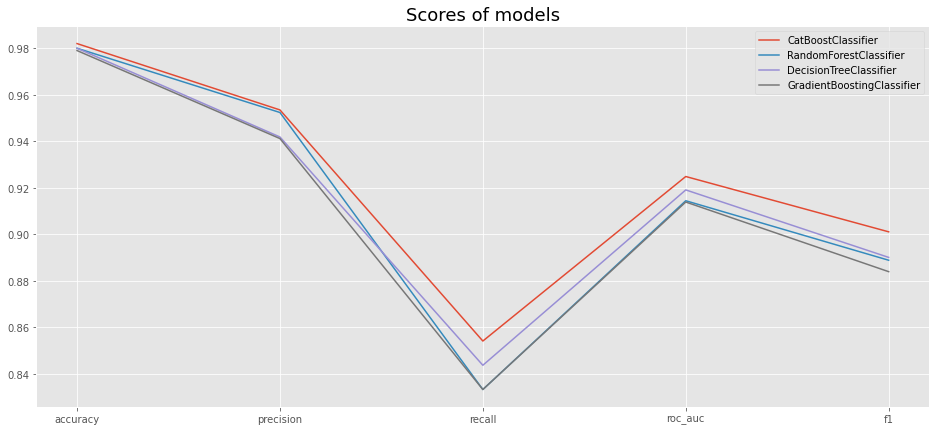

In [47]:
# validation vizualiazation
fig = plt.figure(figsize=(16, 7))
for i in range(len(scoring_df)):
    plt.plot(metrics.keys(), scoring_df.loc[i, metrics.keys()].values, label=scoring_df['model'][i])

plt.title('Scores of models', fontsize=18)
plt.legend();


Видим, что лучше всего себя показывают градиентный бустинг и случайный лес. Однако решающее дерево не сильно уступает двум данным моделям. Логистическая регрессия имеет наиболее низкий score.
Следовательно, наиболее оптимальным вариантом в данной задаче является использование решающего дерева в качестве финальной модели (за счет хорошей интерпритируемости).

Сохраним также модель с наибольшим показателем качества - случайный лес.

In [48]:
# final model with simple interpritetion
dtc = best_params['DecisionTreeClassifier']

#saving model
joblib.dump(dtc, 'models\DTree_model.pkl')

# final score

prob_preds = dtc.predict_proba(X_test)[:, 1]
preds = dtc.predict(X_test)
for score_name, score in metrics.items():
    try:
        print(score_name+': '+str(score(y_test,prob_preds)))
    except:
        print(score_name+': '+str(score(y_test,preds)))

accuracy: 0.98
precision: 0.9418604651162791
recall: 0.84375
roc_auc: 0.9842655328171092
f1: 0.8901098901098902


In [49]:
# final model with better results
rfc = best_params['RandomForestClassifier']
print('RandomForest')
#saving model
joblib.dump(rfc, 'models\\rfc_model.pkl')

# final score

prob_preds = rfc.predict_proba(X_test)[:, 1]
preds = rfc.predict(X_test)
for score_name, score in metrics.items():
    try:
        print(score_name+': '+str(score(y_test,prob_preds)))
    except:
        print(score_name+': '+str(score(y_test,preds)))
cb = best_params['CatBoostClassifier']

#saving model
joblib.dump(rfc, 'models\\cb_model.pkl')

# final score
print('CatBoost')
prob_preds = cb.predict_proba(X_test)[:, 1]
preds = cb.predict(X_test)
for score_name, score in metrics.items():
    try:
        print(score_name+': '+str(score(y_test,prob_preds)))
    except:
        print(score_name+': '+str(score(y_test,preds)))

RandomForest
accuracy: 0.98
precision: 0.9523809523809523
recall: 0.8333333333333334
roc_auc: 0.9953908554572272
f1: 0.888888888888889
CatBoost
accuracy: 0.982
precision: 0.9534883720930233
recall: 0.8541666666666666
roc_auc: 0.9972690818584071
f1: 0.9010989010989011


In [50]:
cb.get_feature_importance(prettified=True)

,Feature Id,Importances
0,Income,25.173037
1,Education,17.329937
2,Family,17.020981
3,CCAvg,16.327025
4,IsEducated,6.989863
5,Mortgage,3.200943
6,CD Account,3.196562
7,IsCCAvg75,2.725055
8,IsIncome75,2.470609
9,Online,2.400872


In [51]:
import shap
shap.initjs()

ModuleNotFoundError: No module named 'shap'

In [ ]:
explainer = shap.TreeExplainer(cb)
shap_values = explainer.shap_values(X_test)

In [ ]:
%matplotlib inline

In [ ]:
from random import randint
rid = randint(0,X_test.shape[1]) 
label = cb.predict(X_test.iloc[rid,:])
proba = cb.predict_proba(X_test.iloc[rid,:])[label]


shap.force_plot(explainer.expected_value, shap_values[rid,:], X_test.iloc[rid,:],
                #out_names=f'with {proba:.3f} probability',
                #figsize=(19, 5),
                link="logit", 
                #text_rotation=15,
                #matplotlib=True,
               )

#### Таким образом мы получили хорошее качество классификации, высокую точность и достаточно большую полноту, что должно хорошо сказаться на экономической значимости, и наша кампании принесет больше прибыли, чем предыдущая

Как мы знаем, деревья решений можно легко интерпретировать с помощью визуализации бинарного дерева. Для этого нам понадобится вернуть данные в исходное состояние, и проделать все те же преобразования без этапа нормализации.

In [ ]:
# preprocessing for ddtc

# pipeline with no normalization layer
pipe_raw = data_engeneering_pipeline[:2]

# getting new X_train & X_test (Non-normalized)
X_train_raw = pipe_raw.fit_transform(X_train_raw)
X_test_raw = pipe_raw.fit_transform(X_test_raw)

# stealing params from dtc
dtc_raw = DecisionTreeClassifier()
params = dtc.get_params()
dtc_raw.set_params(**params)

# fti & evaluate
dtc_raw.fit(X_train_raw, y_train)

prob_preds = dtc_raw.predict_proba(X_test)[:, 1]
preds = dtc_raw.predict(X_test)
for score_name, score in metrics.items():
    try:
        print(score_name+': '+str(score(y_test, prob_preds)))
    except:
        print(score_name+': '+str(score(y_test, preds)))

Здесь происходит визуализация, но для ее корректной работы нужно поставить несколько библиотек и обновить переменные среды


In [ ]:
#!pip install pydot
#!pip install graphviz

In [ ]:

# visualization
#import graphviz

# DOT data
#dot_data = tree.export_graphviz(dtc_raw, out_file=None, 
#                                feature_names=train_columns,  
#                                class_names=['1', '0'],
#                               filled=True)

# Draw graph
#graph = graphviz.Source(dot_data, format="png") 
#graph.save('dtc_raw_tree.dot')


In [ ]:
# export to png
#import pydot

#(graph,) = pydot.graph_from_dot_file('dtc_raw_tree.dot')
#graph.write_png('dtc_raw_tree.png')

Теперь в readme у нас есть картинка с интерпритацией

<a id='conclusion_cell'></a>

### Оценка экономической эфффективности 

In [ ]:
dtc_preds = dtc.predict(X_test)
conversion_rate_old = float(y_test.sum() / y_test.shape[0])
conversion_rate_new = precision_score(y_test, dtc_preds)
missing_clients = 1 - recall_score(y_test, dtc_preds)
percent_of_new_candidates = dtc_preds.sum()/y_test.shape[0]
print(f'Старый показатель конверсии на тестовой выборке равен {conversion_rate_old * 100:.1f}%')
print(f'Новый показатель конверсии на тестовой выборке равен {conversion_rate_new * 100:.1f}%')
print(f'Потеряно {missing_clients * 100:.1f}% клиентов')
print(f'Количество новых кандидатов относительно старого способа составляет {percent_of_new_candidates* 100:.1f}%')

Пусть затраты на маркетинг на одного клиента __N__, доход с одного клиента __M__, общее количеств клиентов __n__

Profit_old = (M * 0.092 - N) * n

Profit_new = (M * 0.897  - N) * 0.087 * n 

Delta = (-0.013 * M + 0.913 * N) * n                       

Допустим что, изначально было 5000 клиентов, на привлечение клиента мы тратим 50 рублей, а потенциальный профит составляет 1000 рублей, то при внедрении нашей системы мы получим 163250 рублей
Таким образом внедрение нашей модели позволит увеличить доход банка. 

In [ ]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))